# Group Project 2

### Alex Hausser, Devin Hayes, Galen Sieck, Minh Nguyen, Vivek Nair

In this project, you will implement a numerical method to study the wave equation. The wave equation
is one of the most important partial differential equations in engineering because it is used to model many
relevant systems, such as seismic waves, deformation of elastic rods (and related elastic media), motion
of strings, and dynamics of acoustic waves (i.e., sound)! In one spatial dimension (1D), the simplest form
that the wave equation takes is,

$$
\frac{\partial^2{u}}{\partial{t}^2} = c^2 \frac{\partial^2{u}}{\partial{x}^2}
$$

where c is a constant referred to as the wave speed. There are many variants to eq. (1) that can arise from
having a wave speed c that depends on space, presence of a prescribed forcing function, etc. Different
initial and boundary conditions, which depend on the problem being chosen, will also change the solution.
For this project, please do the following:

1) Define a system of interest to your group that can be meaningfully modelled using a variant of the wave equation and choose parameters for that system, as needed for eq. (1). You are encouraged to use curiosity when defining this system, but your final choice for the form of the wave equation and associated parameters should be informed by some research into the problem. I suggest you stick to one of the following topics: (i) deformation of elastic rods, (ii) acoustics, or (iii) seismic waves, since these topics lead to interesting models using a 1D wave equation. There are other topics (e.g., the motion of a plucked string) that can be modeled by the wave equation, but these require at least two spatial dimensions which is beyond the scope of this class.

2) Select and implement an appropriate numerical method/methods to simulate your system. You have freedom here, for example, you can choose a finite different method, finite element method, or something not covered in class. Even if you use a finite difference or finite element method, you can choose one not covered in class. You must write your solver from scratch, that is, you may not use an existing Python method like scipy.integrate.rk45.

3) Write a report summarizing your problem, numerical method, results, and conclusions. Some expectations for the report are below:

(a) Your report should be written in AIAA format (section headings are up to you). Word and LaTeX templates can be found here: https://www.aiaa.org/events-learning/events/Technical- Presenter-Resources.

(b) There is maximum page limit of 6 pages, excluding references and an appendix (the appendix has a maximum page limit of 4 pages). You can use an appendix to include information that is helpful but not necessary to your main story.

(c) Your report should have a professional tone appropriate for a technical document.

(d) Your system should be clearly defined. That is, you should clearly specify which variant of the wave equation you are using (e.g., do you need a spatially varying wave speed) and what associated parameters you choose. You should justify these choices by including references
when possible.

(e) The numerical method/methods you use should be clearly defined and justified (using arguments of accuracy and stability from class). You should NOT re-derive any results that are commonly known, but you SHOULD specify any details that are unique to your implementation or were not covered in class (e.g., if you choose a method not covered in class, you should define the key equations).

(f) Your results should demonstrate that you have correctly implemented your method/methods using a convergence test (i.e., comparing the scaling of your error to the expected scaling for various choices of Δx and Δt).

(g) Your results should include analysis of your system dynamics under various meaningfully selected parameter settings.

(h) Any plots should be clear and concise in showing the desired information. Notice that for N ≥ 3, you will need to think about meaningful ways to visualize results. A crucial piece of being an engineer is conveying technical information in a concise, visually appealing manner. 

Since this is a project, you are expected to go well beyond what is typical of a homework submission and take ownership of your work on this project. Going “beyond what is typical” can mean different things to different teams. For some, that may mean exploring new numerical methods we did not consider in class. For others, it may mean taking a method/methods used in class and extensively exploring your system. Either approach is great; just be sure to work hard and have fun! 

You will work in a small assigned groups. You may split up the work as you see fit. For example, everyone can equally contribute to every part of the project or you can provide team leads for various parts (like defining the problem statement, picking and implementing the method, writing the report, etc.) Whatever approach you take, make sure that every group member contributes meaningfully to the project. You will all fill out a confidential survey after submitting your work, and if there is a consensus that one or more of the team members was not a significant contributor, there will be a substantial grade based penalty depending on the severity of the infraction.

In [33]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
n = 1000
b = 5
a = 0
T = 5

**G Functions**

In [3]:
# Sin(pi*x) Forcing Function
def g_function(x_points_array, t):
    top_half = np.zeros(n-1)
    bottom_half = np.sin(np.pi*x_points_array)
    ans = np.concatenate((top_half, bottom_half))
    return ans

In [4]:
# 0 forcing function
def g_function0(x_points_array, t):
    return np.zeros(2*n-2)

In [5]:
# constant forcing function
def g_functionc(x_points_array, t):
    top_half = np.zeros(n-1)
    bottom_half = np.ones(n-1)
    ans = np.concatenate((top_half, bottom_half))
    return ans

**Exact Solution**

In [35]:
def analytical(x, t, E, rho):
    c = np.sqrt(E/rho)
    u_e = np.sin(np.pi/5*x)*np.cos(np.pi/5*c*t)
    return u_e

**Trapezoidal Method**

In [29]:
def get_A_matrix(n, dx, rho, E):
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()
    
    
    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    return A

In [10]:
# Knowns
T = 5
a = 0
b = 5
n = 1000

# Sine Forcing Function
def trapIVP(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    A = get_A_matrix(n, dx, rho, E)
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        g_tk = g_function(x_interp_cut, times[i])
        g_tkp1 = g_function(x_interp_cut, times[i] + dt)
        RHS = U[i] + (dt/2) * (A @ U[i] + g_tk + g_tkp1)
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:999]
    
    return U, times, x_interp_cut

In [27]:
# 0 Forcing Function
def trapIVP0(E, rho, dt, n):
    # Define dx
    dx = 5/n
    
    A = get_A_matrix(n, dx, rho, E)

    
    # Define I matrix
    I = sp.eye(2*n-2)
    
    # # Define timesteps
    # t_step = int(T/dt) + 1
    # times = np.linspace(0, T, t_step)
    
    # # Define interpolation points
    # x_interp = np.linspace(a, b, n+1)
    
    # # Define interpolation points removing the boundaries
    # x_interp_cut = x_interp[1:-1]

    x_steps = int(abs(b-a)/dx)
    x_interp_cut = np.linspace(a + dx, b - dx, x_steps-1)
    num_timesteps = int(T/dt)
    times = np.linspace(0,T,num_timesteps+1)
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        # g_tk = g_function0(x_interp_cut, times[i])
        # g_tkp1 = g_function0(x_interp_cut, times[i] + dt)
        RHS = U[i] + (dt/2) * (A @ U[i])
        U[i+1] = np.array(spsolve(LHS, RHS))
    
    # Cut U to only give displacements
    print("U ", U.shape)
    U = U[:,0:(n-1)]
    print('U ', U.shape)
    
    # Get U Analytical
    U_e = []
    for time in range(len(times)-1):
        U_e.append(analytical(x_interp_cut, time, E, rho))
    
    return U, times, x_interp_cut, U_e

U  (101, 1998)
U  (0, 1998)
[1 2 3]


In [10]:
# 0 Forcing Function
def trapIVPc(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    A = get_A_matrix(n, dx, rho, E)
    
    # Define I matrix
    I = np.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    x_steps = int(abs(b-a)/dx)
    x_interp_cut = np.linspace(a + dx, b - dx, x_steps-1)
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        g_tk = g_functionc(x_interp_cut, times[i])
        g_tkp1 = g_functionc(x_interp_cut, times[i] + dt)
        RHS = U[i] + (dt/2) * (A @ U[i] + g_tk + g_tkp1)
        U[i+1] = spsolve(LHS, RHS)
    
    # Cut U to only give displacements
    U = U[: , 0:-1]
    
    return U, times, x_interp_cut

**Forward Euler**

In [90]:
# Zero Forcing Function
def FEIVP0(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = sp.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        RHS = U[i] + (dt) * (A @ U[i])
        U[i+1] = np.array(spsolve(LHS, RHS))
    
    # Cut U to only give displacements
    U = U[:,0:(n-1)]
    
    return U, times, x_interp_cut

**Displacement Over Bar Data**

In [ ]:
# All Displacements at each time step
U1, times, x_int, U1e = trapIVP0(70, 2700, dt, n) # zero forcing function
U2 = FEIVP0(70, 2700, dt, n)[0] # Aluminum Alloy
U3, times, x_int = trapIVP(70, 2700, dt, n) # sine forcing function
U4, times, x_int = trapIVPc(70, 2700, dt, n) # constant forcing function

# Trap Displacements at different times
U1_t0 = U1[0]
U1_t5 = U1[-1]
U3_t0 = U3[0]
U3_t5 = U3[-1]
U4_t0 = U4[0]
U4_t5 = U4[-1]

# FE Displacements at different times
U2_t0 = U2[0]
U2_t5 = U2[-1]

# Analytical Displacements
U1e_t0 = U1e[0]
U1e_t5 = U1e[-1]

/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


**Trapezoidal, Aluminum Alloy under different forcing functions**

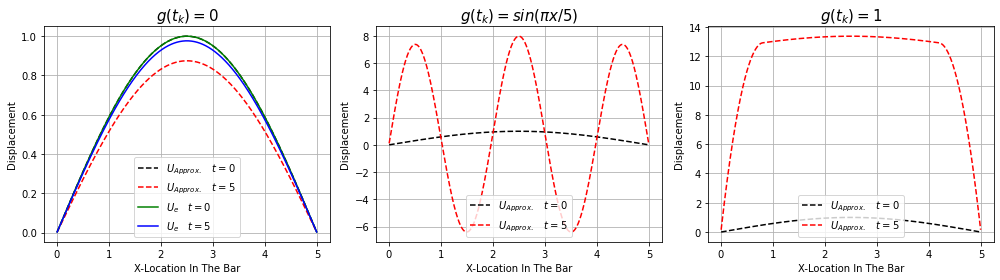

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(131)
ax1.plot(x_int, U1_t0, 'k--', label=r'$U_{Approx.} \quad t=0$')
ax1.plot(x_int, U1_t5, 'r--', label=r'$U_{Approx.} \quad t=5$')
ax1.plot(x_int, U1e_t0, 'g', label=r'$U_e \quad t=0$')
ax1.plot(x_int, U1e_t5, 'b', label=r'$U_e \quad t=5$')
ax1.set_xlabel('X-Location In The Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.grid()
ax1.set_title(r'$g(t_k)=0$', size=15) # Trapezoidal Method (Al Alloy)
ax1.legend(loc='lower center')

ax2 = fig.add_subplot(132)
ax2.plot(x_int, U3_t0, 'k--', label=r'$U_{Approx.} \quad t=0$')
ax2.plot(x_int, U3_t5, 'r--', label=r'$U_{Approx.} \quad t=5$')
ax2.set_xlabel('X-Location In The Bar')
ax2.set_ylabel('Displacement')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.grid()
ax2.set_title(r'$g(t_k)=sin(\pi x/5)$', size=15) # Trapezoidal Method (Al Alloy)
ax2.legend(loc='lower center')

ax3 = fig.add_subplot(133)
ax3.plot(x_int, U4_t0, 'k--', label=r'$U_{Approx.} \quad t=0$')
ax3.plot(x_int, U4_t5, 'r--', label=r'$U_{Approx.} \quad t=5$')
ax3.set_xlabel('X-Location In The Bar')
ax3.set_ylabel('Displacement')
ax3.set_xscale('linear')
ax3.set_yscale('linear')
ax3.grid()
ax3.set_title(r'$g(t_k)=1$', size=15) # Trapezoidal Method (Al Alloy)
ax3.legend(loc='lower center');

**Forward Euler, Aluminum Alloy under 0 forcing function**

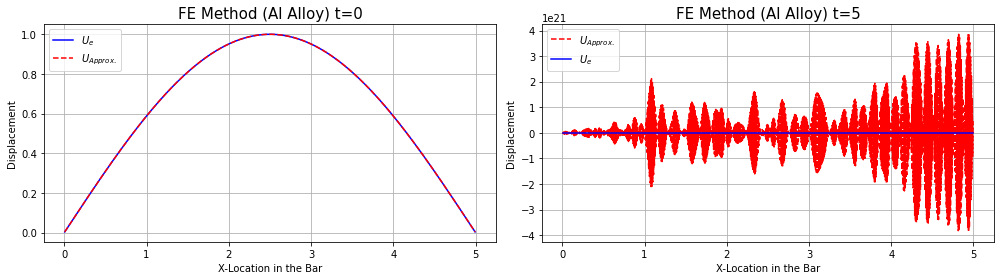

In [13]:
fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(121)
ax1.plot(x_int, U1e_t0, 'b', label=r'$U_e$')
ax1.plot(x_int, U2_t0, 'r--', label=r'$U_{Approx.}$')
ax1.set_xlabel('X-Location in the Bar')
ax1.set_ylabel('Displacement')
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.grid()
ax1.set_title('FE Method (Al Alloy) t=0', size=15)
ax1.legend(loc='upper left')

ax2 = fig.add_subplot(122)
ax2.plot(x_int, U2_t5, 'r--', label=r'$U_{Approx.}$')
ax2.plot(x_int, U1e_t5, 'b', label=r'$U_e$')
ax2.set_xlabel('X-Location in the Bar')
ax2.set_ylabel('Displacement')
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.grid()
ax2.set_title('FE Method (Al Alloy) t=5', size=15)
ax2.legend(loc='upper left');

**Max Displacement Data Sine Forcing Function**

In [28]:
umax1 = np.max(U3) # Aluminum Alloy
umax2 = np.max(trapIVP(95, 8300, dt, n)[0]) # Brass
umax3 = np.max(trapIVP(114, 8500, dt, n)[0]) # Copper
umax4 = np.max(trapIVP(17.5, 11300, dt, n)[0]) # Lead
umax5 = np.max(trapIVP(210, 7800, dt, n)[0]) # Steel
umax6 = np.max(trapIVP(55, 1870, dt, n)[0]) # Glass 
umax7 = np.max(trapIVP(26, 2700, dt, n)[0]) # Granite
umax8 = np.max(trapIVP(63, 2600, dt, n)[0]) # Limestone
umax9 = np.max(trapIVP(2.5, 490, dt, n)[0]) # Perspex

umax11 = np.max(U1) # Aluminum Alloy
umax22 = np.max(trapIVP0(95, 8300, dt, n)[0]) # Brass
umax33 = np.max(trapIVP0(114, 8500, dt, n)[0]) # Copper
umax44 = np.max(trapIVP0(17.5, 11300, dt, n)[0]) # Lead
umax55 = np.max(trapIVP0(210, 7800, dt, n)[0]) # Steel
umax66 = np.max(trapIVP0(55, 1870, dt, n)[0]) # Glass 
umax77 = np.max(trapIVP0(26, 2700, dt, n)[0]) # Granite
umax88 = np.max(trapIVP0(63, 2600, dt, n)[0]) # Limestone
umax99 = np.max(trapIVP0(2.5, 490, dt, n)[0]) # Perspex

umax111 = np.max(U4) # Aluminum Alloy
umax222 = np.max(trapIVPc(95, 8300, dt, n)[0]) # Brass
umax333 = np.max(trapIVPc(114, 8500, dt, n)[0]) # Copper
umax444 = np.max(trapIVPc(17.5, 11300, dt, n)[0]) # Lead
umax555 = np.max(trapIVPc(210, 7800, dt, n)[0]) # Steel
umax666 = np.max(trapIVPc(55, 1870, dt, n)[0]) # Glass 
umax777 = np.max(trapIVPc(26, 2700, dt, n)[0]) # Granite
umax888 = np.max(trapIVPc(63, 2600, dt, n)[0]) # Limestone
umax999 = np.max(trapIVPc(2.5, 490, dt, n)[0]) # Perspex

C:\Anaconda\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:144: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format

  warn('spsolve requires A be CSC or CSR matrix format',


In [29]:
print(f'Sine Forcing Function: {[umax1, umax2, umax3, umax4, umax5, umax6, umax7, umax8, umax9]}')

Sine Forcing Function: [7.980897179365077, 10.765341137741142, 10.345704505398002, 13.099294930360696, 7.813337168695195, 7.408515230237838, 11.16548205193882, 8.27178397062508, 12.217217783424143]


In [32]:
print(f'Zero Forcing Function: {[umax11, umax22, umax33, umax44, umax55, umax66, umax77, umax88, umax99]}')

Zero Forcing Function: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [33]:
print(f'Constant Forcing Function: {[umax111, umax222, umax333, umax444, umax555, umax666, umax777, umax888, umax999]}')

Constant Forcing Function: [13.374765720955892, 13.444047191444971, 13.434542639021275, 13.492367344826036, 13.37005663911469, 13.35833674069066, 13.452854968190067, 13.382790575986075, 13.474927953669436]


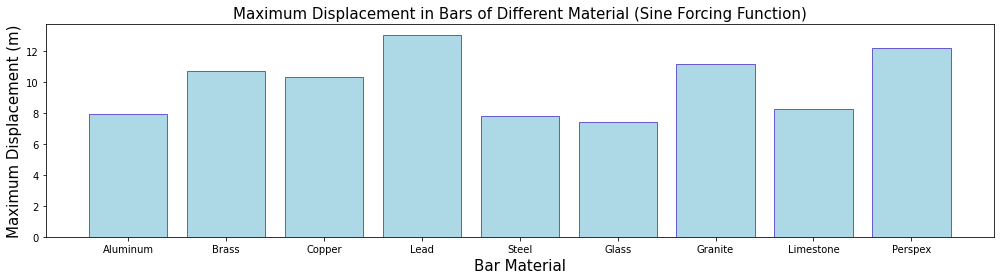

In [34]:
Max_disp_data = [umax1, umax2, umax3, umax4, umax5, umax6, umax7, umax8, umax9]
Material_data = ['Aluminum', 'Brass', 'Copper', 'Lead', 'Steel', 'Glass', 'Granite', 'Limestone', 'Perspex']

fig = plt.figure(figsize=(14, 4), tight_layout=True)
ax1 = fig.add_subplot(111)
ax1.bar(Material_data, Max_disp_data, color='lightblue', edgecolor='slateblue')
ax1.set_xlabel('Bar Material', size=15)
ax1.set_ylabel('Maximum Displacement (m)', size=15)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xticks(np.arange(9), Material_data)
ax1.set_title('Maximum Displacement in Bars of Different Material (Sine Forcing Function)', size=15);

**Error Functions**

In [88]:
def trapIVPerror(E, rho, dt, n):
    U, times, x_interp_cut, U_e = trapIVP0(E, rho, dt, n)
    
    U_base = analytical(x_interp_cut, 5, rho, E)
    print(U_base.shape)
    print(U.shape)
    
    top = U[-1] - U_base
    bot = U_base
    err = np.linalg.norm(top) / np.linalg.norm(bot)
    return err

In [84]:
def FEIVPerror(E, rho, dt, n):
    U, t, xc, = FEIVP0(E, rho, dt, n)

    U_base = analytical(xc, 5, rho, E)
    print(U_base.shape)
    print(U.shape)
    
    top = U[-1] - U_base
    bot = U_base
    err = np.linalg.norm(top) / np.linalg.norm(bot)

    return err


In [91]:
dt_list = [1, 0.5, 0.25, 0.1, 0.05]

# Data List
err_list = []
err_list_2 = []

for dt in dt_list:
    # Get errors
    err_trap = trapIVPerror(2700, 70, dt, 10)
    err_trap_2 = FEIVPerror(2700, 70, dt, 10)

    # Save data to lists
    err_list.append(err_trap)
    err_list_2.append(err_trap_2)
    
# Expected Behavior


U  (6, 18)
U  (6, 9)
(9,)
(6, 9)
(9,)
(6, 9)
U  (11, 18)
U  (11, 9)
(9,)
(11, 9)
(9,)
(11, 9)
U  (21, 18)
U  (21, 9)
(9,)
(21, 9)
(9,)
(21, 9)
U  (51, 18)
U  (51, 9)
(9,)
(51, 9)
(9,)
(51, 9)


c:\Users\Galen\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


U  (101, 18)
U  (101, 9)
(9,)
(101, 9)
(9,)
(101, 9)


In [96]:
M = dt_list[-1]**2/err_list[-1]
errP = [x**2/M for x in dt_list]
M2 = dt_list[-1]/err_list_2[-1]
errP_2 = [x/M2 for x in dt_list]

In [44]:
print(err_list)

[0.1431633808785851, 0.14316338087858513, 0.1431633808785851, 0.14316338087858513, 0.14316338087858513]


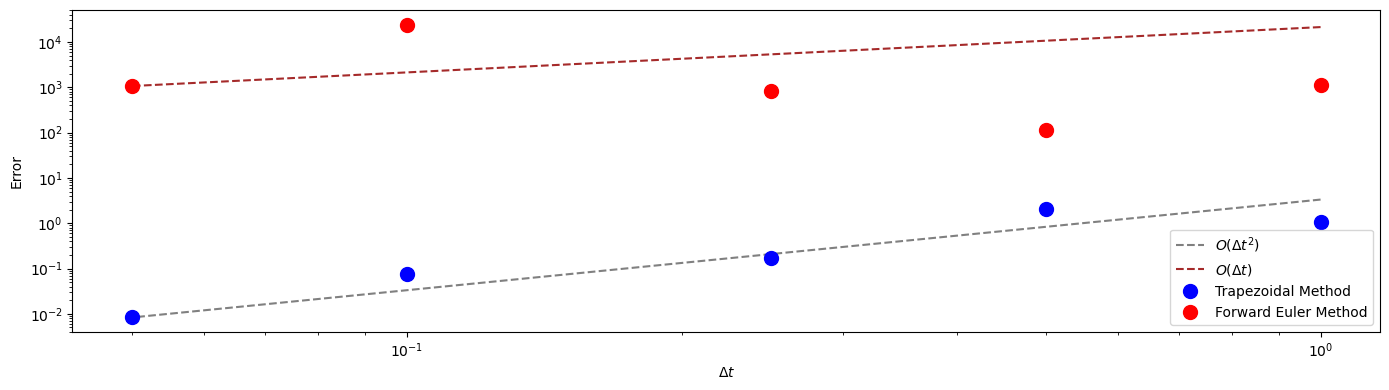

In [97]:
# Error Plot
fig = plt.figure(figsize=(14, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dt_list, errP, color='grey', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dt_list, errP_2, color='brown', linestyle='--', label='$O(\Delta t)$')
ax.plot(dt_list, err_list,'bo', label = 'Trapezoidal Method', markersize='10')
ax.plot(dt_list, err_list_2,'ro', label = 'Forward Euler Method', markersize='10')
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [46]:
def trap_ivp_spat_error(E, rho, dt, n, U_base):
    U, times, x_interp_cut, U_e = trapIVP0(E, rho, dt, n)
    
    top = abs(np.linalg.norm(U[-1] )- np.linalg.norm(U_base))
    bot = U_base
    err = top / np.linalg.norm(bot)
    return err

In [101]:
n_list = [1, 500, 10000]
dx_list = [(5)/n for n in n_list]

# Data List
err_list = []

U_base, t, x_i, u_e = trapIVP0(2700, 70, 0.1, 3000)
U_base = U_base[-1]

for n in n_list:
    # Get errors
    err_trap = trap_ivp_spat_error(2700, 70, 1, n, U_base)

    # Save data to lists
    err_list.append(err_trap)
    

M = dx_list[-1]**2/err_list[-1]
errP = [x**2/M for x in dx_list]

U  (51, 5998)
U  (51, 2999)
U  (6, 0)
U  (6, 0)
U  (6, 998)
U  (6, 499)
U  (6, 19998)
U  (6, 9999)


In [103]:
print(err_list)

[1.0, 0.9893570001437183, 0.9524163726097288]


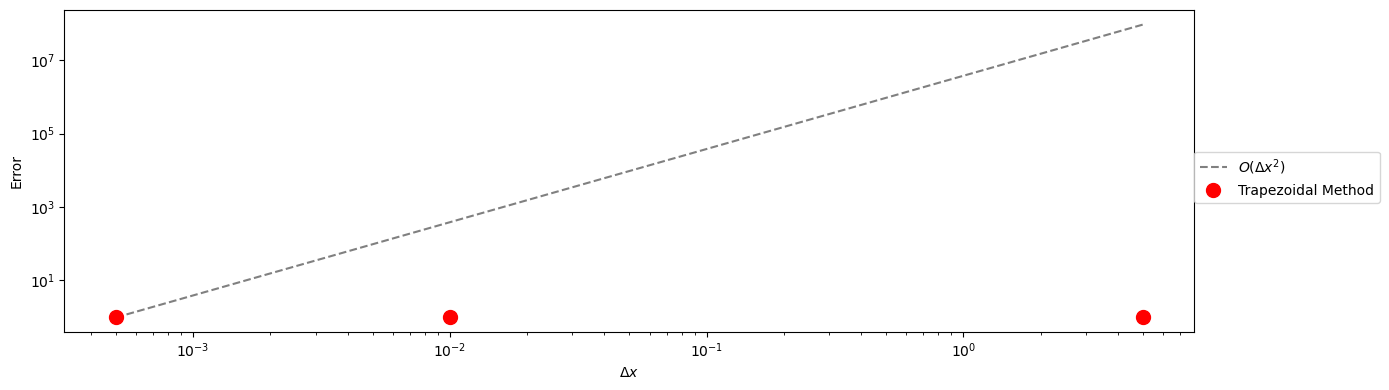

In [102]:
# Error Plot
fig = plt.figure(figsize=(14, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dx_list, errP, color='grey', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dx_list, err_list,'ro', label = 'Trapezoidal Method', markersize='10')
ax.set_xlabel('$\Delta x$')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=(1, 0.4))

**A Matrix Scratch**

In [ ]:
ind = np.arange(0, 2*n-2, 1)
ones = np.ones(n-1)
dx = (b-a) / n
rho = 2700
E = 70
coef = rho*dx**2/E

ind_top_half_rows = ind[0:999]
ind_top_half_cols = ind[999:]
ind_bot_half_rows = ind[999:]
ind_bot_half_cols = ind[0:999]

# Add -2 diagonal
neg2s = -2*ones
A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

# Add top 1 diagonal
A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

# Add bottom 1 diagonal
A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

# Add top diagonal
coefs = coef*ones
A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

A = A*E/(rho*dx**2)

A.toarray()[998]

In [9]:
def A_matrix(a, b, c, n):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = 1/(c/dx)**2
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coefficient outside the matrix
    A = A*(1/coef)

    I = sp.eye(2*n-2)
    
    return A, I

def trap_step(A, I, dt, u_k):
    # Define left hand side of system
    LHS = I - (dt/2)*A
    RHS = u_k + (dt/2) * (A @ u_k)
    u_k_plus1 = np.array(spsolve(LHS, RHS))
    return u_k_plus1

def trap_solver(a, b, c, n, dt, T):
    # Define A Matrix
    A, I = A_matrix(a, b, c, n)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
#     u0s = np.zeros(n-1)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    for i in range(len(times)-1):
        U[i+1] = trap_step(A, I, dt, U[i])
        
    # Cut U to only give displacements
    U = U[: , 0:n-1]
    
    # U_true
    U_true = np.sin(np.pi*x_interp_cut/(b-a))
    
    return U, x_interp_cut, U_true

In [20]:
def analytical2(x, t, c):
    u_e = np.sin(np.pi/5*x)*np.cos(np.pi/5*c*t)
    return u_e

In [17]:
def error(a, b, c, n, dt):
    U, x_interp_cut, U_true = trap_solver(a, b, c, n, dt, 5)

    U_base = analytical2(x_interp_cut, 5, c)
    
    top = U[-1] - U_base
    bot = U_base
    err = np.linalg.norm(top) / np.linalg.norm(bot)
    return err

In [21]:
dt_list = [1, 0.5, 0.25, 0.1, 0.05]

# Data List
err_list = []

for dt in dt_list:
    # Get errors
    err_trap = error(0, 5, 5300, 1000, dt)

    # Save data to lists
    err_list.append(err_trap)
    
# Expected Behavior
M = dt_list[-1]**2/err_list[-1]
errP = [x**2/M for x in dt_list]

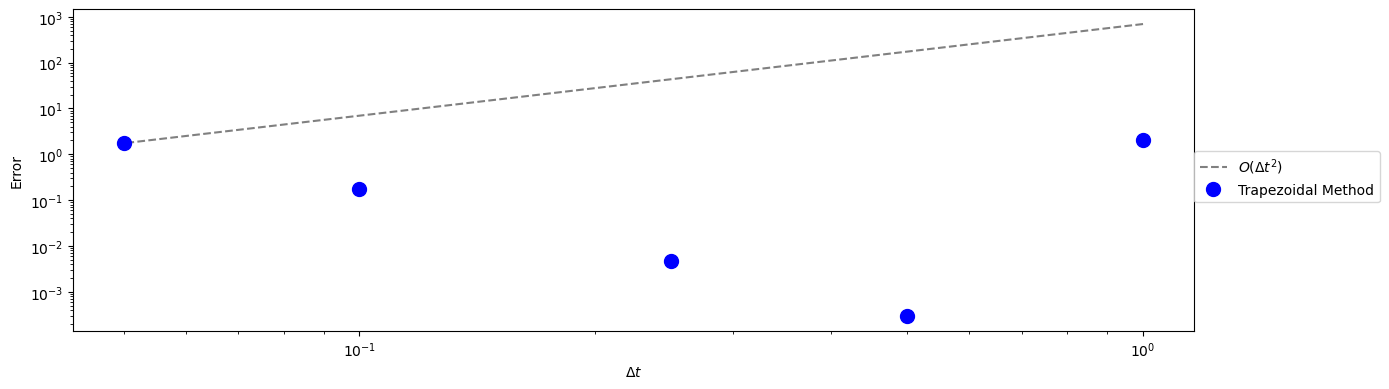

In [22]:
fig = plt.figure(figsize=(14, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dt_list, errP, color='grey', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dt_list, err_list,'bo', label = 'Trapezoidal Method', markersize='10')
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc=(1, 0.4))